In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

In [2]:
# load dataset
data = pd.read_csv('data.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data

(19, 29)


,Id,Name,Rent,StrtName,Storeys,Cheaperflrs,Electricity,RefDisposal,RunWater,SecPost,...,RdCond,SecurityLvl,RmSize,RmCond,Wdrobe,Finishing,Balcony,KitchenSize,BathrmSize,BalcnySize
0,1101,Ezinne lodge,225000,Ezinne lodge,3,No,Yes,Yes,Yes,Yes,...,2,4,3,5,Yes,Tiles,Yes,3,3,3
1,1102,Unity palace,120000,Chalgrove,1,No,Yes,Yes,Yes,No,...,3,4,4,3,No,Tiles,Yes,3,5,3
2,1103,Sylgor,20000,Ezinne lodge,2,No,Yes,Yes,Yes,No,...,2,2,4,4,Yes,Tiles,Yes,5,4,5
3,1104,Great Achievers Home,130000,Great Achievers Home,2,No,No,No,No,No,...,2,2,5,4,No,Tiles,Yes,4,5,4
4,1105,Edwins Lodge,150000,Chimamanda Lodge,3,I don't know,Yes,No,No,No,...,3,3,2,3,Yes,Tiles,Yes,1,1,2
5,1106,Andy's villa,100000,Ambassador's lodge,2,Yes,Yes,No,No,No,...,3,3,3,3,Yes,Tiles,No,3,3,3
6,1107,Dominion city,160000,Dominion city,2,No,Yes,No,No,Yes,...,3,4,4,4,Yes,Tiles,No,2,2,2
7,1108,Excellent’s Lodge,140000,St. Nicholas,2,I don't know,Yes,No,No,No,...,3,4,3,3,Yes,Tiles,Yes,4,4,4
8,1109,Oslo villa,110000,Oslo villa,3,Yes,Yes,Yes,No,Yes,...,1,4,3,3,No,Tiles,Yes,3,3,0
9,1110,St Joseph,70000,Davida lodge,3,Yes,Yes,No,No,No,...,3,2,3,4,Yes,Tiles,No,3,3,1


In [3]:
print(data.dtypes)


Id              int64
Name           object
Rent            int64
StrtName       object
Storeys         int64
Cheaperflrs    object
Electricity    object
RefDisposal    object
RunWater       object
SecPost        object
Cleaners       object
LodgeGen       object
Solar          object
LgCond          int64
Age             int64
GenHouse       object
Parking        object
Distance        int64
Location       object
RdCond          int64
SecurityLvl     int64
RmSize          int64
RmCond          int64
Wdrobe         object
Finishing      object
Balcony        object
KitchenSize     int64
BathrmSize      int64
BalcnySize      int64
dtype: object


In [4]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'Rent'], axis=1), # predictive variables
    data['Rent'], # target
    test_size=0.3, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((13, 27), (6, 27))

In [5]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [6]:
# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['KitchenSize', 'BathrmSize', 'BalcnySize']

# variables to map
SOME_VARS = ['Cheaperflrs', 'Electricity', 'RefDisposal',
             'RunWater', 'SecPost', 'Cleaners', 'LodgeGen',
             'Solar', 'GenHouse', 'Parking', 'Wdrobe', 'Balcony']

# categorical variables to encode
LOCATION_VARS = ['Location']

FINISHING_VARS = ['Finishing']

# variable mappings
SOME_MAPPINGS = {'No':1, 'I don\'t know':2,
                 'Yes':3}

LOCATION_MAPPINGS = {'Near Eziobodo Gate':1, 'Near Sekani':2,
                     'Around John Paul\'s Kitchen':3, 'Dombolo':4,
                     'Eziobodo Elu':5}

FINISHING_MAPPINGS = {'Tiles':1, 'Cement':2}

# the selected variables
FEATURES = ['Storeys',
            'Cheaperflrs',
            'Electricity',
            'RefDisposal',
            'RunWater',
            'SecPost',
            'Cleaners',
            'LodgeGen',
            'Solar',
            'LgCond',
            'Age',
            'GenHouse',
            'Parking',
            'Distance',
            'Location',
            'RdCond',
            'SecurityLvl',
            'RmSize',
            'RmCond',
            'Wdrobe',
            'Finishing',
            'Balcony',
            'KitchenSize',
            'BathrmSize',
            'BalcnySize'
]





In [7]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((13, 25), (6, 25))

In [25]:
price_pipe = Pipeline([
        # === mappers ===
    ('mapper_SOME', pp.Mapper(
        variables=SOME_VARS, mappings=SOME_MAPPINGS)),
    
    ('mapper_LOCATION', pp.Mapper(
        variables=LOCATION_VARS, mappings=LOCATION_MAPPINGS)),
    ('mapper_FINISHING', pp.Mapper(
        variables=FINISHING_VARS, mappings=FINISHING_MAPPINGS)),
        
    ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('Lasso', Lasso(alpha=0.1, random_state=0))
])

In [26]:
# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('mapper_SOME',
                 Mapper(mappings={"I don't know": 2, 'No': 1, 'Yes': 3},
                        variables=['Cheaperflrs', 'Electricity', 'RefDisposal',
                                   'RunWater', 'SecPost', 'Cleaners',
                                   'LodgeGen', 'Solar', 'GenHouse', 'Parking',
                                   'Wdrobe', 'Balcony'])),
                ('mapper_LOCATION',
                 Mapper(mappings={"Around John Paul's Kitchen": 3, 'Dombolo': 4,
                                  'Eziobodo Elu': 5, 'Near Eziobodo Gate': 1,
                                  'Near Sekani': 2},
                        variables=['Location'])),
                ('mapper_FINISHING',
                 Mapper(mappings={'Cement': 2, 'Tiles': 1},
                        variables=['Finishing'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.1, random_state=0))])

In [27]:
# evaluate the model:
# ====================

# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average lodge price: ', int(np.exp(y_train).median()))

train mse: 2156002626
train rmse: 46432
train r2: 0.1899412097255141

test mse: 1088181153
test rmse: 32987
test r2: -0.30581738386990565

Average lodge price:  139999


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

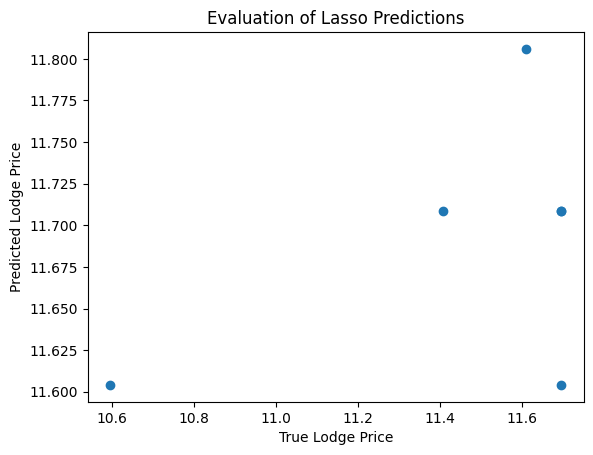

In [28]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True Lodge Price')
plt.ylabel('Predicted Lodge Price')
plt.title('Evaluation of Lasso Predictions')

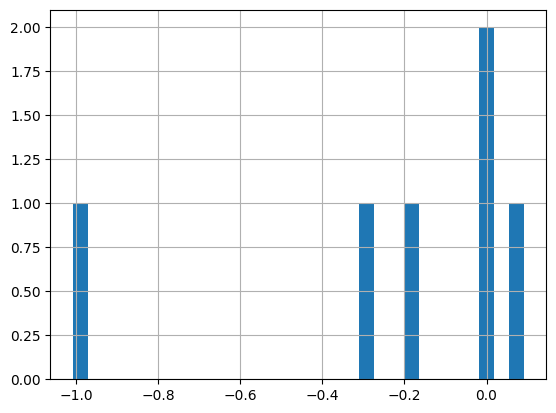

In [29]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [30]:
# now let's save the scaler

joblib.dump(price_pipe, 'price_pipe.joblib') 

['price_pipe.joblib']

In [31]:
# load the unseen / new dataset
data = pd.read_csv('test.csv')

data.drop('Id', axis=1, inplace=True)

data = data[FEATURES]

print(data.shape)

(5, 25)


In [16]:
new_preds = price_pipe.predict(data)

<Axes: >

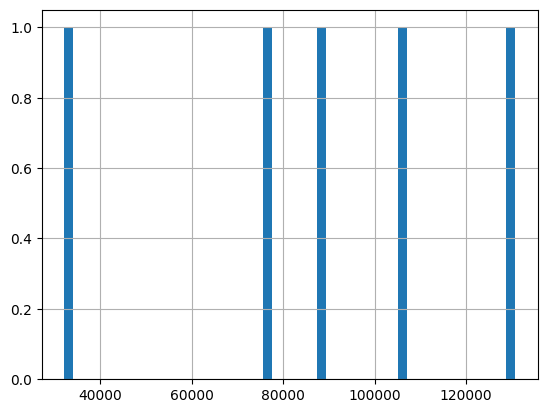

In [32]:
# let's plot the predicted sale prices
pd.Series(np.exp(new_preds)).hist(bins=50)